In [6]:
#Code to find audio file information
import soundfile as sf

# Load file
file_path = "vowel1_1.wav"
data, samplerate = sf.read(file_path)

# Basic info
num_samples = len(data)
num_channels = 1 if data.ndim == 1 else data.shape[1]
duration_sec = num_samples / samplerate

# Print results
print(f"📄 File: {file_path}")
print(f"🔢 Sample Rate     : {samplerate} Hz")
print(f"🔊 Number of Channels : {num_channels}")
print(f"🔁 Total Samples   : {num_samples}")
print(f"⏱️ Duration        : {duration_sec:.3f} seconds")


📄 File: vowel1_1.wav
🔢 Sample Rate     : 44100 Hz
🔊 Number of Channels : 1
🔁 Total Samples   : 10912
⏱️ Duration        : 0.247 seconds


In [7]:
#Code to find formants according to paper.

import numpy as np
import soundfile as sf
from numpy import hamming
from scipy.linalg import solve_toeplitz
from numpy.polynomial import Polynomial

# === Step 0: Load and Normalize the WAV File ===
filename = "vowel1_1.wav"
signal, fs = sf.read(filename)
signal = signal / np.max(np.abs(signal))

# === Step 1: Extract 30ms Frame Centered at 0.12379s ===
center_time = 0.12379
frame_len = int(0.030 * fs)
center_sample = int(center_time * fs)
start = max(0, center_sample - frame_len // 2)
frame = signal[start:start + frame_len]
windowed_frame = frame * hamming(len(frame))

# === Step 2: LPC Analysis ===
p = int(fs / 1000) + 2  # Data-driven LPC order
def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1], -a))

a_lpc = compute_lpc_autocorr(windowed_frame, p)

# === Step 3: Root Extraction and Formant Screening ===
roots = np.roots(a_lpc)
roots = roots[np.imag(roots) >= 0.01]  # Real-axis rejection

def root_to_formant(root, fs):
    r = np.abs(root)
    theta = np.angle(root)
    freq = theta * fs / (2 * np.pi)
    bw = -fs / np.pi * np.log(r)
    return freq, bw

formants, bandwidths, complex_roots = [], [], []
for z in roots:
    r = np.abs(z)
    if 0.75 <= r < 1:
        f, b = root_to_formant(z, fs)
        if 90 < f < fs / 2:
            formants.append(f)
            bandwidths.append(b)
            complex_roots.append(z)

formants = np.array(formants)
bandwidths = np.array(bandwidths)
complex_roots = np.array(complex_roots)
sorted_idx = np.argsort(formants)
formants = formants[sorted_idx]
bandwidths = bandwidths[sorted_idx]
complex_roots = complex_roots[sorted_idx]

print("✅ Total valid formants:", len(formants))
for i, (f, b) in enumerate(zip(formants, bandwidths)):
    print(f"F{i+1} = {f:.2f} Hz\tB{i+1} = {b:.2f} Hz")

# === Step 4: Merger Detection Based on Angle Criterion ===
merger_pairs = []
for i in range(len(complex_roots)):
    for j in range(i+1, len(complex_roots)):
        z1, z2 = complex_roots[i], complex_roots[j]
        r = (np.abs(z1) + np.abs(z2)) / 2
        theta1, theta2 = np.angle(z1), np.angle(z2)
        try:
            threshold = 2 * np.arccos(2 * r / (1 + r**2))
            if abs(theta1 - theta2) < threshold:
                merger_pairs.append((i, j))
        except:
            continue

print("\n🔍 Suspicious merger pairs (angle check):", merger_pairs)

# === Step 5: Cauchy Integral Pole Confirmation ===
def cauchy_integral_count(a_coeffs, theta1, theta2):
    N = 300
    r_cauchy = 0.875
    ts = np.linspace(theta1, theta2, N)
    z = r_cauchy * np.exp(1j * ts)
    A = np.polyval(a_coeffs[::-1], z)
    Aprime = np.polyval(np.polyder(a_coeffs[::-1]), z)
    integrand = Aprime / A
    dz = np.gradient(z)
    integral = np.sum(integrand * dz)
    return int(np.round(np.real(integral / (2j * np.pi))))

confirmed_mergers = []
for i, j in merger_pairs:
    z1, z2 = complex_roots[i], complex_roots[j]
    theta1, theta2 = np.angle(z1), np.angle(z2)
    count = cauchy_integral_count(a_lpc, min(theta1, theta2), max(theta1, theta2))
    print(f"  → Cauchy check for pair F{i+1}-F{j+1}: {count} poles")
    if count == 2:
        confirmed_mergers.append((i, j))

print("\n✅ Confirmed mergers:", confirmed_mergers)

# === Step 6: Polynomial Decomposition with Correction ===
def poly_decomp_separate(a_coeffs, z1, z2):
    p = len(a_coeffs) - 1
    fz = Polynomial(a_coeffs[::-1]).convert().coef
    fz = np.concatenate([fz, np.zeros(p)])

    r1 = np.abs(z1)
    theta1 = np.angle(z1)
    z1_mean = r1 * np.exp(1j * theta1)
    z2_mean = np.conj(z1_mean)
    s = - (z1_mean + z2_mean).real
    t = (r1 ** 2)

    b = np.zeros(p - 1)
    b[0] = 1
    for k in range(1, p - 1):
        b[k] = fz[k] - s * b[k - 1] - t * (b[k - 2] if k > 1 else 0)

    alpha = fz[p - 1] - s * b[-1] - t * b[-2]
    beta = fz[p] - t * b[-1]

    c = np.zeros(p - 2)
    c[0] = 1
    for k in range(1, p - 2):
        c[k] = b[k] - s * c[k - 1] - t * (c[k - 2] if k > 1 else 0)

    R11 = b[-1] - s * c[-1] - t * c[-2]
    R21 = -t * c[-1]
    R12 = b[-2] - s * c[-2] - t * c[-3]
    R22 = b[-1] - t * c[-2]

    A = np.array([[R11, R12], [R21, R22]])
    rhs = np.array([alpha, beta])
    u, v = np.linalg.solve(A, rhs)

    s1 = s + u
    t1 = t + v
    new_roots = np.roots([1, s1, t1])
    return new_roots

# === Step 7: Reconstruct Separated Roots ===
separated_roots = []
used_indices = set()
for i, j in confirmed_mergers:
    z1, z2 = complex_roots[i], complex_roots[j]
    new_roots = poly_decomp_separate(a_lpc, z1, z2)
    print(f"\n🧩 Decomposed roots for F{i+1}, F{j+1}:", new_roots)
    separated_roots.extend(new_roots)
    used_indices.update([i, j])

# Include all unused original roots
for i, z in enumerate(complex_roots):
    if i not in used_indices:
        separated_roots.append(z)

# === Step 8: Final Formant and Bandwidth Estimation ===
formants_final, bandwidths_final = [], []
for z in separated_roots:
    r, theta = np.abs(z), np.angle(z)
    if 0.75 <= r < 1:
        f = (theta * fs) / (2 * np.pi)
        b = -(fs / np.pi) * np.log(r)
        if 90 < f < fs / 2:
            formants_final.append(f)
            bandwidths_final.append(b)

formants_final = np.array(formants_final)
bandwidths_final = np.array(bandwidths_final)
idx = np.argsort(formants_final)
formants_final = formants_final[idx][:5]
bandwidths_final = bandwidths_final[idx][:5]

# === Step 9: Display Results ===
print("\n🎯 Final PDLPC Estimated Formants and Bandwidths:")
for i in range(len(formants_final)):
    print(f"F{i+1} = {formants_final[i]:.2f} Hz\tB{i+1} = {bandwidths_final[i]:.2f} Hz")


✅ Total valid formants: 22
F1 = 511.71 Hz	B1 = 195.62 Hz
F2 = 921.91 Hz	B2 = 106.88 Hz
F3 = 2597.66 Hz	B3 = 105.77 Hz
F4 = 3376.37 Hz	B4 = 143.36 Hz
F5 = 3719.28 Hz	B5 = 388.90 Hz
F6 = 5071.14 Hz	B6 = 810.17 Hz
F7 = 6321.38 Hz	B7 = 706.88 Hz
F8 = 7347.75 Hz	B8 = 790.93 Hz
F9 = 8309.04 Hz	B9 = 1613.44 Hz
F10 = 9046.88 Hz	B10 = 539.13 Hz
F11 = 10316.02 Hz	B11 = 459.51 Hz
F12 = 11220.58 Hz	B12 = 649.73 Hz
F13 = 12283.39 Hz	B13 = 371.81 Hz
F14 = 13469.34 Hz	B14 = 544.21 Hz
F15 = 14413.48 Hz	B15 = 763.83 Hz
F16 = 15433.88 Hz	B16 = 691.71 Hz
F17 = 16453.57 Hz	B17 = 987.66 Hz
F18 = 17185.48 Hz	B18 = 955.20 Hz
F19 = 18489.79 Hz	B19 = 946.73 Hz
F20 = 19386.98 Hz	B20 = 2232.01 Hz
F21 = 19648.68 Hz	B21 = 640.27 Hz
F22 = 20903.83 Hz	B22 = 827.01 Hz

🔍 Suspicious merger pairs (angle check): [(7, 8), (8, 9), (16, 17), (18, 19), (19, 20)]
  → Cauchy check for pair F8-F9: 0 poles
  → Cauchy check for pair F9-F10: 0 poles
  → Cauchy check for pair F17-F18: 0 poles
  → Cauchy check for pair F19-F20: 0 p

In [8]:
#Batch processing code.

import numpy as np
import soundfile as sf
from numpy import hamming
from scipy.linalg import solve_toeplitz
from numpy.polynomial import Polynomial
import pandas as pd
import os

def process_vowel_file(filepath, fs_expected=44100):
    try:
        signal, fs = sf.read(filepath)
        if fs != fs_expected:
            raise ValueError(f"Unexpected sample rate in {filepath}: {fs}")
        signal = signal / np.max(np.abs(signal))

        # Step 1: Frame centered at 0.12379s
        center_time = 0.10
        frame_len = int(0.060 * fs)#60 ms window
        center_sample = int(center_time * fs)
        start = max(0, center_sample - frame_len // 2)
        frame = signal[start:start + frame_len]
        windowed_frame = frame * hamming(len(frame))

        # Step 2: LPC analysis
        p = int(fs / 1000) + 2
        def compute_lpc_autocorr(x, order):
            x = x - np.mean(x)
            r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
            R = r[:order + 1]
            r_rhs = r[1:]
            a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
            return np.concatenate(([1], -a))

        a_lpc = compute_lpc_autocorr(windowed_frame, p)

        # Step 3: Root filtering
        roots = np.roots(a_lpc)
        roots = roots[np.imag(roots) >= 0.01]

        def root_to_formant(root, fs):
            r = np.abs(root)
            theta = np.angle(root)
            freq = theta * fs / (2 * np.pi)
            bw = -fs / np.pi * np.log(r)
            return freq, bw

        formants, bandwidths, complex_roots = [], [], []
        for z in roots:
            r = np.abs(z)
            if 0.75 <= r < 1:
                f, b = root_to_formant(z, fs)
                if 90 < f < fs / 2:
                    formants.append(f)
                    bandwidths.append(b)
                    complex_roots.append(z)

        formants = np.array(formants)
        bandwidths = np.array(bandwidths)
        sorted_idx = np.argsort(formants)
        formants = formants[sorted_idx][:5]
        bandwidths = bandwidths[sorted_idx][:5]

        while len(formants) < 5:
            formants = np.append(formants, np.nan)
            bandwidths = np.append(bandwidths, np.nan)

        return formants.tolist() + bandwidths.tolist()

    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return [np.nan] * 10

# === Batch processing loop ===
results = []
for i in range(1, 41):
    filename = f"vowel1_{i}.wav"
    if os.path.exists(filename):
        features = process_vowel_file(filename)
        results.append([filename] + features)
    else:
        print(f"File not found: {filename}")
        results.append([filename] + [np.nan]*10)

# === Save results to CSV ===
columns = ["filename", "F1", "F2", "F3", "F4", "F5", "B1", "B2", "B3", "B4", "B5"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("vowel1_formants_bandwidths.csv", index=False)


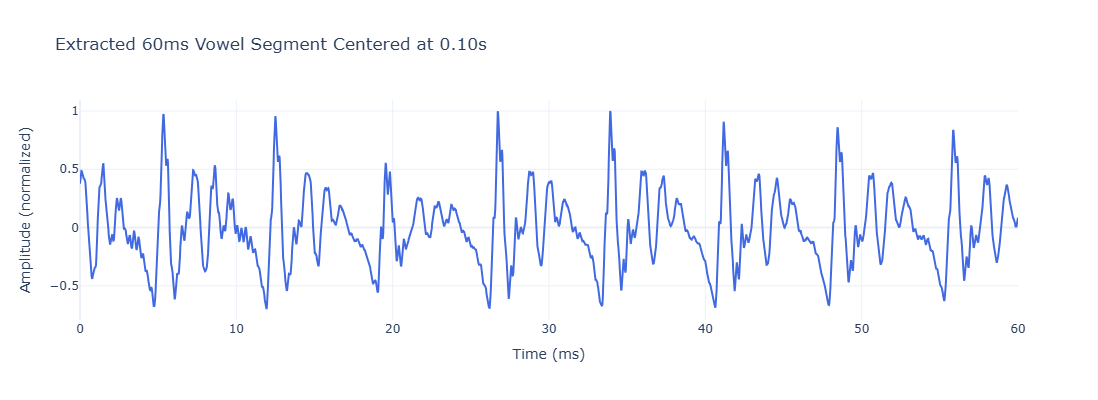

In [1]:
import numpy as np
import soundfile as sf
import plotly.graph_objects as go

# === Step 0: Load and Normalize Audio ===
file_path = "vowel1_1.wav"
signal, fs = sf.read(file_path)
signal = signal / np.max(np.abs(signal))  # normalize

# === Step 1: Extract 60ms Frame Centered at 0.10s ===
center_time = 0.10  # seconds
frame_duration = 0.060  # 60 ms
frame_len = int(frame_duration * fs)
center_sample = int(center_time * fs)
start = max(0, center_sample - frame_len // 2)
end = start + frame_len
frame = signal[start:end]

# Time axis for plotting (in milliseconds)
time_ms = np.linspace(0, frame_duration * 1000, len(frame))  # 0 to 60 ms

# === Step 2: Plot with Plotly ===
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=time_ms,
    y=frame,
    mode='lines',
    name='60ms segment',
    line=dict(color='royalblue')
))

fig.update_layout(
    title="Extracted 60ms Vowel Segment Centered at 0.10s",
    xaxis_title="Time (ms)",
    yaxis_title="Amplitude (normalized)",
    template="plotly_white",
    width=800,
    height=400,
    xaxis=dict(range=[0, frame_duration * 1000])
)

fig.show()


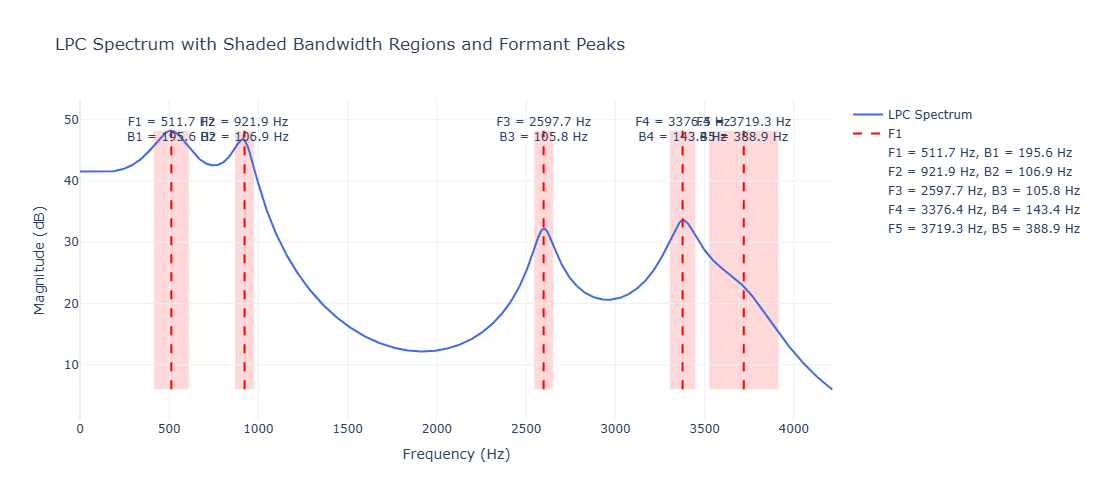

In [9]:
import numpy as np
import soundfile as sf
import plotly.graph_objects as go
from scipy.signal import freqz
from scipy.linalg import solve_toeplitz
from numpy import hamming

# === Step 0: Load audio and extract 30ms frame ===
file_path = "vowel1_1.wav"
signal, fs = sf.read(file_path)
signal = signal / np.max(np.abs(signal))  # normalize

center_time = 0.12379  # seconds
frame_len = int(0.030 * fs)  # 30 ms
center_sample = int(center_time * fs)
start = center_sample - frame_len // 2
frame = signal[start:start + frame_len]
windowed_frame = frame * hamming(len(frame))

# === Step 1: LPC Coefficients ===
p = int(fs / 1000) + 2  # LPC order (44 for 44.1kHz)
def compute_lpc_autocorr(x, order):
    x = x - np.mean(x)
    r = np.correlate(x, x, mode='full')[len(x)-1:len(x)+order]
    R = r[:order + 1]
    r_rhs = r[1:]
    a = solve_toeplitz((R[:-1], R[:-1]), r_rhs)
    return np.concatenate(([1], -a))

a_lpc = compute_lpc_autocorr(windowed_frame, p)

# === Step 2: Formant and Bandwidths (from previous output) ===
formants_final = np.array([511.71, 921.91, 2597.66, 3376.37, 3719.28])
bandwidths_final = np.array([195.62, 106.88, 105.77, 143.36, 388.90])

# === Step 3: LPC Spectrum ===
w, h = freqz([1], a_lpc, worN=4096, fs=fs)
spectrum = 20 * np.log10(np.abs(h))

# === Step 4: Limit x-axis to F5 + 500 Hz ===
f_max = formants_final[4] + 500
mask = w <= f_max
w_plot = w[mask]
spectrum_plot = spectrum[mask]
y_min = min(spectrum_plot)
y_max = max(spectrum_plot)

# === Step 5: Plot ===
fig = go.Figure()

# LPC Spectrum
fig.add_trace(go.Scatter(
    x=w_plot,
    y=spectrum_plot,
    mode='lines',
    name='LPC Spectrum',
    line=dict(color='royalblue')
))

# Formant bands and markers
for i, (f, b) in enumerate(zip(formants_final, bandwidths_final)):
    bw_half = b / 2
    f_left = f - bw_half
    f_right = f + bw_half

    # Shaded Bandwidth Region
    fig.add_shape(
        type="rect",
        x0=f_left, x1=f_right,
        y0=y_min, y1=y_max,
        fillcolor="rgba(255,0,0,0.15)",
        line=dict(width=0),
        layer="below"
    )

    # Vertical Line at Formant Peak
    fig.add_trace(go.Scatter(
        x=[f, f],
        y=[y_min, y_max],
        mode='lines',
        line=dict(color='red', dash='dash'),
        name=f"F{i+1}",
        showlegend=(i == 0)  # Only show 'F1' label once
    ))

    # Text Annotation at peak
    fig.add_trace(go.Scatter(
        x=[f],
        y=[y_max],
        text=[f"F{i+1} = {f:.1f} Hz<br>B{i+1} = {b:.1f} Hz"],
        mode='text',
        showlegend=False
    ))

# === Step 5.5: Add invisible traces to legend with F and B values ===
for i, (f, b) in enumerate(zip(formants_final, bandwidths_final)):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='lines',
        line=dict(color='white'),
        name=f"F{i+1} = {f:.1f} Hz, B{i+1} = {b:.1f} Hz"
    ))

# === Step 6: Final Layout ===
fig.update_layout(
    title="LPC Spectrum with Shaded Bandwidth Regions and Formant Peaks",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Magnitude (dB)",
    template="plotly_white",
    width=950,
    height=500,
    xaxis=dict(range=[0, f_max]),
    yaxis=dict(range=[y_min - 5, y_max + 5])
)

fig.show()


✅ Hankel matrix shape: (1323, 1324)
✅ SVD complete


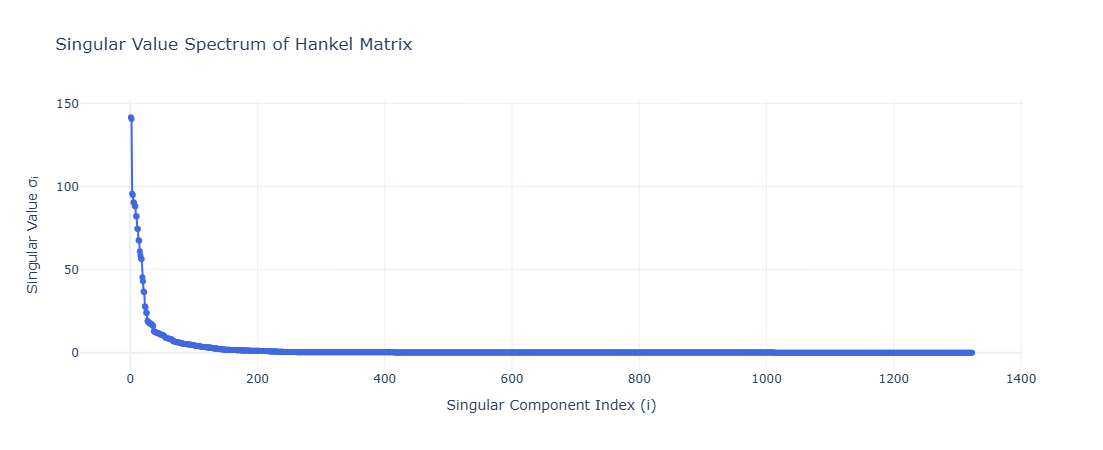

In [10]:
#Singular value code and plot.

import numpy as np
import soundfile as sf
import plotly.graph_objs as go
from scipy.linalg import svd

# === Step 1: Load and normalize signal ===
file_path = "vowel1_1.wav"
signal, fs = sf.read(file_path)
signal = signal / np.max(np.abs(signal))  # Normalize to [-1, 1]

# === Step 2: Extract 60 ms segment centered at 0.12379s ===
center_time = 0.12379  # in seconds
frame_len = int(0.060 * fs)  # 60 ms frame
center_sample = int(center_time * fs)
start = center_sample - frame_len // 2
end = center_sample + frame_len // 2
segment = signal[start:end]

# === Step 3: Construct Hankel matrix with L = N/2 ===
N = len(segment)
L = N // 2
K = N - L + 1
hankel_matrix = np.column_stack([segment[i:i+L] for i in range(K)])

print(f"✅ Hankel matrix shape: {hankel_matrix.shape}")

# === Step 4: Apply SVD ===
U, S, VT = svd(hankel_matrix, full_matrices=False)
print("✅ SVD complete")

# === Step 5: Plot singular value spectrum using Plotly ===
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(1, len(S)+1),
    y=S,
    mode='lines+markers',
    name='Singular Values',
    marker=dict(size=6),
    line=dict(color='royalblue')
))
fig.update_layout(
    title="Singular Value Spectrum of Hankel Matrix",
    xaxis_title="Singular Component Index (i)",
    yaxis_title="Singular Value σᵢ",
    template="plotly_white",
    width=800,
    height=450
)
fig.show()


In [13]:
#Weighted peak frequency summary

import numpy as np
import pandas as pd

# === Assumed already available from your previous processing ===
# fs = 44100  # or from your WAV file
# formants_final = np.array([...])
# bandwidths_final = np.array([...])
# hankel_matrix = ...  # from your 60ms segment
# U, S, VT = np.linalg.svd(hankel_matrix, full_matrices=False)

L = hankel_matrix.shape[0]
K = hankel_matrix.shape[1]
num_components = L // 2  # Use only first L/2 components

# === Formant-bandwidth pairs ===
formant_band_pairs = list(zip(formants_final, bandwidths_final))

# === Anti-diagonal averaging helper ===
def average_anti_diagonals(matrix):
    rows, cols = matrix.shape
    N = rows + cols - 1
    result = np.zeros(N)
    count = np.zeros(N)
    for i in range(rows):
        for j in range(cols):
            result[i + j] += matrix[i, j]
            count[i + j] += 1
    return result / count

# === Formant contribution analysis from top L/2 components ===
formant_contributions = {f"F{i+1}": [] for i in range(len(formant_band_pairs))}

for i in range(num_components):
    Hi = S[i] * np.outer(U[:, i], VT[i, :])
    signal_i = average_anti_diagonals(Hi)
    signal_i *= np.hamming(len(signal_i))  # windowing
    spectrum = np.abs(np.fft.rfft(signal_i))
    freqs = np.fft.rfftfreq(len(signal_i), d=1/fs)

    peak_idx = np.argmax(spectrum)
    peak_freq = freqs[peak_idx]
    peak_mag = spectrum[peak_idx]

    for j, (f, bw) in enumerate(formant_band_pairs):
        lower = f - bw / 2
        upper = f + bw / 2
        if lower <= peak_freq <= upper:
            formant_contributions[f"F{j+1}"].append((i + 1, peak_freq, peak_mag))

# === Weighted peak frequency summary per formant ===
rows = []
for label, contributors in formant_contributions.items():
    if contributors:
        total_weight = sum(mag for _, _, mag in contributors)
        weighted_freq = sum(freq * mag for _, freq, mag in contributors) / total_weight
        formant_index = int(label[1:]) - 1
        formant_freq, bandwidth = formant_band_pairs[formant_index]

        rows.append({
            "Formant": label,
            "Formant Freq (Hz)": round(formant_freq, 2),
            "Bandwidth (Hz)": round(bandwidth, 2),
            "Weighted SVD Peak Freq (Hz)": round(weighted_freq, 2),
            "Num Contributing SVD Components": len(contributors)
        })

df_formant_svd = pd.DataFrame(rows)
print(df_formant_svd)


  Formant  Formant Freq (Hz)  Bandwidth (Hz)  Weighted SVD Peak Freq (Hz)  \
0      F1             511.71          195.62                       529.18   
1      F2             921.91          106.88                       938.44   
2      F3            2597.66          105.77                      2613.38   
3      F4            3376.37          143.36                      3384.81   
4      F5            3719.28          388.90                      3654.78   

   Num Contributing SVD Components  
0                               12  
1                                5  
2                                7  
3                                8  
4                               22  


In [23]:
import numpy as np
import pandas as pd
import soundfile as sf
import os
from scipy.linalg import svd
from tqdm import tqdm  # ✅ Progress bar

# === Load Formant + Bandwidths CSV ===
df_formants = pd.read_csv("vowel1_formants_bandwidths.csv")# Change file name here
df_formants.set_index("filename", inplace=True)

# === Utility: Anti-diagonal averaging ===
def average_anti_diagonals(matrix):
    rows, cols = matrix.shape
    N = rows + cols - 1
    result = np.zeros(N)
    count = np.zeros(N)
    for i in range(rows):
        for j in range(cols):
            result[i + j] += matrix[i, j]
            count[i + j] += 1
    return result / count

# === Main Processing with Progress Bar ===
all_rows = []

print("🔄 Starting SVD + formant contribution extraction for 40 files...\n")

for speaker_id in tqdm(range(1, 41), desc="🔁 Processing files", ncols=80):
    fname = f"vowel1_{speaker_id}.wav" #change name here
    if not os.path.exists(fname):
        print(f"❌ File not found: {fname}")
        continue

    try:
        # Load and normalize
        audio, fs = sf.read(fname)
        audio = audio / np.max(np.abs(audio))

        # Segment (60 ms centered at 0.12379s)
        center_time = 0.12379
        frame_len = int(0.060 * fs)
        center_sample = int(center_time * fs)
        start = center_sample - frame_len // 2
        segment = audio[start:start + frame_len]

        # Get formants + bandwidths
        row_formants = df_formants.loc[fname]
        F_vals = row_formants[["F1", "F2", "F3", "F4", "F5"]].values
        B_vals = row_formants[["B1", "B2", "B3", "B4", "B5"]].values

        formant_band_pairs = list(zip(F_vals, B_vals))

        # Skip if any NaN in formant/bandwidth
        if np.any(np.isnan(F_vals)) or np.any(np.isnan(B_vals)):
            continue

        # Hankel matrix & SVD
        N = len(segment)
        L = N // 2
        K = N - L + 1
        H = np.column_stack([segment[i:i + L] for i in range(K)])

        U, S, VT = svd(H, full_matrices=False)
        num_components = L // 2

        # Initialize dictionary
        formant_contributions = {f"F{i+1}": [] for i in range(5)}

        # Loop through top L/2 SVD components
        for i in range(num_components):
            Hi = S[i] * np.outer(U[:, i], VT[i, :])
            signal_i = average_anti_diagonals(Hi)
            signal_i *= np.hamming(len(signal_i))

            spectrum = np.abs(np.fft.rfft(signal_i))
            freqs = np.fft.rfftfreq(len(signal_i), d=1/fs)

            peak_idx = np.argmax(spectrum)
            peak_freq = freqs[peak_idx]
            peak_mag = spectrum[peak_idx]

            for j, (f, b) in enumerate(formant_band_pairs):
                if f - b/2 <= peak_freq <= f + b/2:
                    formant_contributions[f"F{j+1}"].append((i + 1, peak_freq, peak_mag))

        # Build output row
        row_data = {"filename": fname}
        for i in range(5):
            formant_label = f"F{i+1}"
            f = F_vals[i]
            b = B_vals[i]
            contributors = formant_contributions[formant_label]

            if contributors:
                total_weight = sum(mag for _, _, mag in contributors)
                weighted_freq = sum(freq * mag for _, freq, mag in contributors) / total_weight
                row_data[f"F{i+1}"] = round(f, 2)
                row_data[f"B{i+1}"] = round(b, 2)
                row_data[f"Weighted_Peak_F{i+1}"] = round(weighted_freq, 2)
                row_data[f"Num_Contributors_F{i+1}"] = len(contributors)
            else:
                row_data[f"F{i+1}"] = round(f, 2)
                row_data[f"B{i+1}"] = round(b, 2)
                row_data[f"Weighted_Peak_F{i+1}"] = np.nan
                row_data[f"Num_Contributors_F{i+1}"] = 0

        all_rows.append(row_data)

    except Exception as e:
        print(f"❌ Error processing {fname}: {e}")
        continue

# === Save to DataFrame ===
df_output = pd.DataFrame(all_rows)
df_output.to_csv("vowel1_formant_svd_contributions.csv", index=False)#change name here
print("\n✅ Saved output to: vowel1_formant_svd_contributions.csv")


🔄 Starting SVD + formant contribution extraction for 40 files...



🔁 Processing files: 100%|███████████████████| 40/40 [9:37:12<00:00, 865.80s/it]



✅ Saved output to: vowel1_formant_svd_contributions.csv


In [1]:
# === Fair comparison of models predicting Weighted SVD Peaks ===
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# ---------------- Config ----------------
CSV = "vowel1_formant_svd_contributions.csv"
TEST_SIZE = 0.25
SEED = 42
USE_RIDGE = False     # flip to True if you want a tiny bit of regularization
ALPHA = 1.0
# ---------------------------------------

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# Load and clean
df = pd.read_csv(CSV).dropna(subset=[f"Weighted_Peak_F{i}" for i in range(1,6)]).reset_index(drop=True)

print(f"Rows after cleaning: {len(df)}")

# ===== (A) Multi-output model: predict [WP1..WP5] from all [F1..F5, B1..B5] =====
X_all = df[[f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]].values
Y_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values

Xtr, Xte, Ytr, Yte = train_test_split(X_all, Y_all, test_size=TEST_SIZE, random_state=SEED)

Model = Ridge(alpha=ALPHA) if USE_RIDGE else LinearRegression()
mo = Model.fit(Xtr, Ytr)
Yhat = mo.predict(Xte)

print("\n=== (A) Multi-output: X = [F1..F5,B1..B5]  →  Y = [WP1..WP5]  (TEST set) ===")
for i in range(5):
    r2 = r2_score(Yte[:, i], Yhat[:, i])
    e  = rmse(Yte[:, i], Yhat[:, i])
    print(f"WP{i+1}: RMSE={e:.2f} Hz, R²={r2:.4f}")

# ===== (B) Per-formant models with the SAME protocol: predict WPi from (Fi, Bi) =====
print("\n=== (B) Per-formant: X = (Fi,Bi)  →  Y = WPi  (TEST set, same split protocol) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)
    m = Model.fit(Xtr, ytr)
    yhat = m.predict(Xte)
    r2 = r2_score(yte, yhat)
    e  = rmse(yte, yhat)
    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}")

# ===== (C) (Optional) Per-formant IN-SAMPLE (to show optimism when not splitting) =====
print("\n=== (C) Per-formant: X = (Fi,Bi)  →  Y = WPi  (IN-SAMPLE, NO split) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    m = Model.fit(Xi, yi)
    yhat = m.predict(Xi)
    r2 = r2_score(yi, yhat)
    e  = rmse(yi, yhat)
    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  <-- optimistic (same data used to train & test)")


Rows after cleaning: 37

=== (A) Multi-output: X = [F1..F5,B1..B5]  →  Y = [WP1..WP5]  (TEST set) ===
WP1: RMSE=36.85 Hz, R²=0.9428
WP2: RMSE=45.70 Hz, R²=0.8799
WP3: RMSE=158.92 Hz, R²=0.9047
WP4: RMSE=113.32 Hz, R²=0.8753
WP5: RMSE=112.05 Hz, R²=0.8835

=== (B) Per-formant: X = (Fi,Bi)  →  Y = WPi  (TEST set, same split protocol) ===
WP1: RMSE=43.52 Hz, R²=0.9203
WP2: RMSE=46.93 Hz, R²=0.8734
WP3: RMSE=123.54 Hz, R²=0.9424
WP4: RMSE=107.46 Hz, R²=0.8879
WP5: RMSE=32.43 Hz, R²=0.9902

=== (C) Per-formant: X = (Fi,Bi)  →  Y = WPi  (IN-SAMPLE, NO split) ===
WP1: RMSE=22.48 Hz, R²=0.9615  <-- optimistic (same data used to train & test)
WP2: RMSE=37.36 Hz, R²=0.9134  <-- optimistic (same data used to train & test)
WP3: RMSE=77.87 Hz, R²=0.9694  <-- optimistic (same data used to train & test)
WP4: RMSE=72.35 Hz, R²=0.9654  <-- optimistic (same data used to train & test)
WP5: RMSE=43.33 Hz, R²=0.9820  <-- optimistic (same data used to train & test)


In [2]:
# === Minimal per-formant + inverse correction models ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# ----------------
CSV = "vowel1_formant_svd_contributions.csv"
TEST_SIZE = 0.25
SEED = 42
# ----------------

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# === Load & clean ===
df = pd.read_csv(CSV)
need = [f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)] + [f"Weighted_Peak_F{i}" for i in range(1,6)]
df = df.dropna(subset=need).reset_index(drop=True)
print(f"Rows after cleaning: {len(df)}\n")

# =========================================================
# (A) Per-formant forward models: WP_i ~ F_i, B_i
# =========================================================
print("=== (A) Per-formant forward models: WP_i ~ F_i, B_i (TEST set) ===")
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)

    model = LinearRegression().fit(Xtr, ytr)
    yhat = model.predict(Xte)
    e, r2 = rmse(yte, yhat), r2_score(yte, yhat)
    a, b = model.coef_.tolist()
    c = model.intercept_

    print(f"WP{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  |  ŷ = {a:.4f}·F{i} + {b:.4f}·B{i} + {c:.4f}")

# =========================================================
# (B) Inverse correction models: F_i ~ WP_i
# =========================================================
print("\n=== (B) Inverse correction models: F_i ~ WP_i (TEST set) ===")
for i in range(1,6):
    Xi = df[[f"Weighted_Peak_F{i}"]].values
    yi = df[f"F{i}"].values
    Xtr, Xte, ytr, yte = train_test_split(Xi, yi, test_size=TEST_SIZE, random_state=SEED)

    inv_model = LinearRegression().fit(Xtr, ytr)
    yhat = inv_model.predict(Xte)
    e, r2 = rmse(yte, yhat), r2_score(yte, yhat)
    a = inv_model.coef_[0]
    b = inv_model.intercept_

    print(f"F{i}: RMSE={e:.2f} Hz, R²={r2:.4f}  |  ŷ = {a:.4f}·WP{i} + {b:.4f}")


Rows after cleaning: 37

=== (A) Per-formant forward models: WP_i ~ F_i, B_i (TEST set) ===
WP1: RMSE=43.52 Hz, R²=0.9203  |  ŷ = 0.9704·F1 + 0.0483·B1 + 24.1756
WP2: RMSE=46.93 Hz, R²=0.8734  |  ŷ = 0.8744·F2 + -0.2399·B2 + 161.5303
WP3: RMSE=123.54 Hz, R²=0.9424  |  ŷ = 1.0762·F3 + -0.0149·B3 + -186.2556
WP4: RMSE=107.46 Hz, R²=0.8879  |  ŷ = 0.9665·F4 + -0.1721·B4 + 166.4228
WP5: RMSE=32.43 Hz, R²=0.9902  |  ŷ = 1.0210·F5 + -0.0318·B5 + -78.9442

=== (B) Inverse correction models: F_i ~ WP_i (TEST set) ===
F1: RMSE=27.74 Hz, R²=0.9636  |  ŷ = 1.0083·WP1 + -19.7494
F2: RMSE=29.16 Hz, R²=0.9449  |  ŷ = 0.9580·WP2 + 60.1583
F3: RMSE=108.19 Hz, R²=0.9223  |  ŷ = 0.9035·WP3 + 237.1178
F4: RMSE=153.70 Hz, R²=0.6753  |  ŷ = 0.9331·WP4 + 219.4421
F5: RMSE=33.69 Hz, R²=0.9900  |  ŷ = 0.9611·WP5 + 164.8862


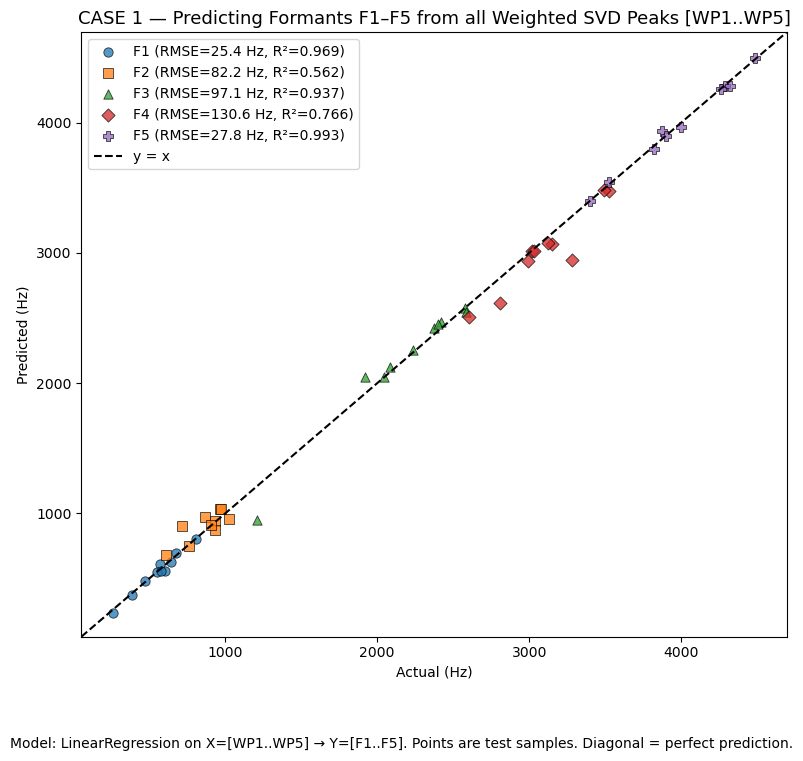

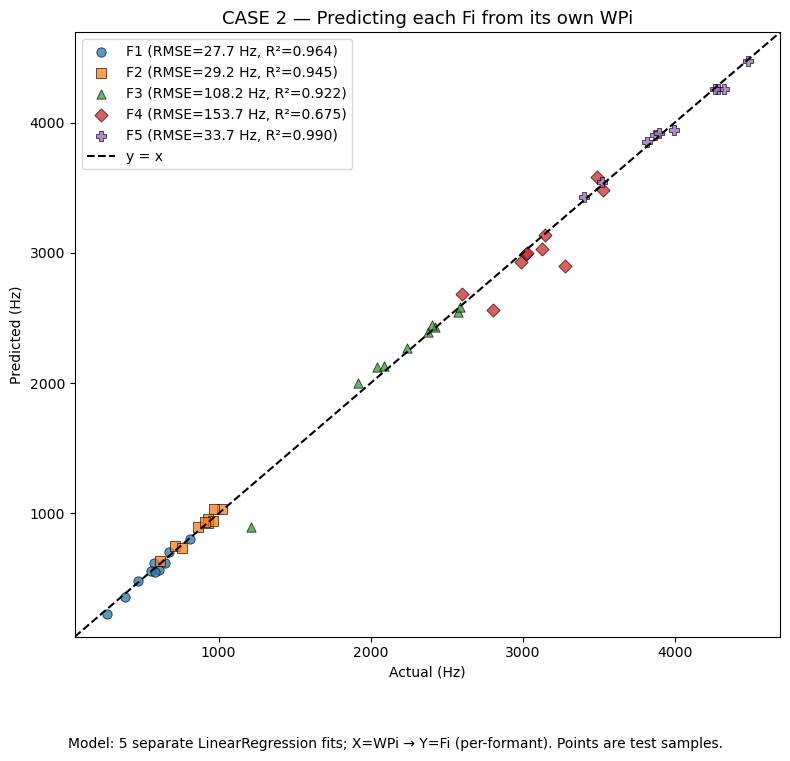

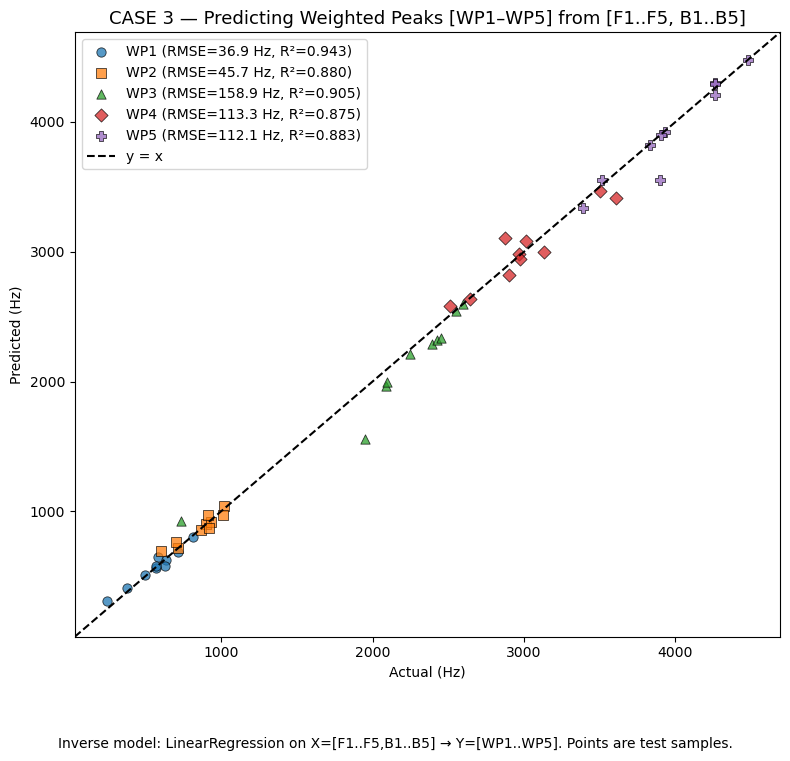

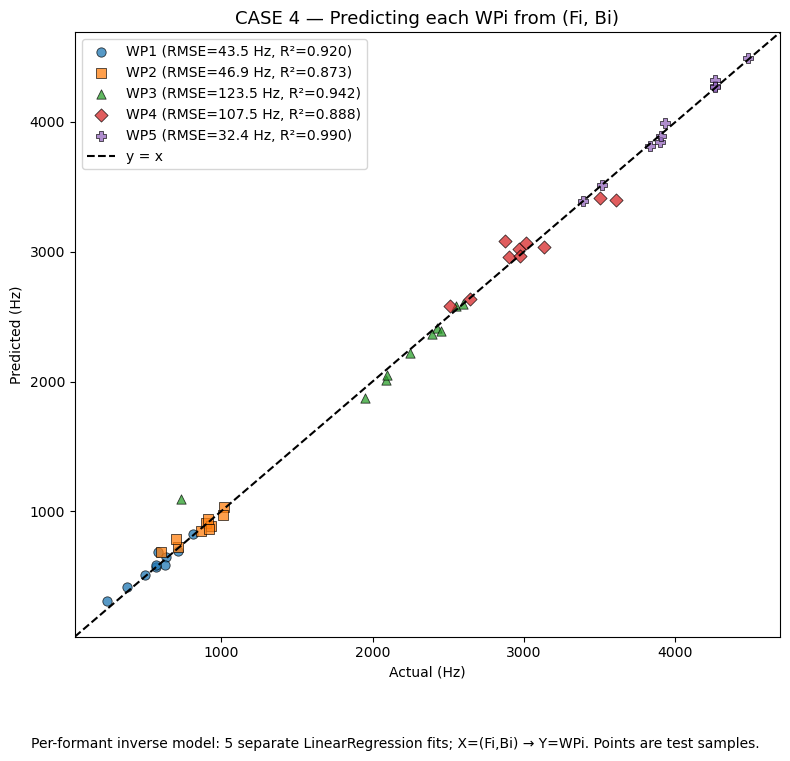

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# === Load & clean ===
df = pd.read_csv("vowel1_formant_svd_contributions.csv")
need = [f"Weighted_Peak_F{i}" for i in range(1,6)] + [f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]
df = df.dropna(subset=need).reset_index(drop=True)

# === Common train/test split indices for fairness across all cases ===
rng_idx = np.arange(len(df))
train_idx, test_idx = train_test_split(rng_idx, test_size=0.25, random_state=42)

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# === Styling ===
colors = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple"]
markers = ["o","s","^","D","P"]
formants = [f"F{i}" for i in range(1,6)]

def plot_one_figure(all_pairs, title, caption, xlab="Actual (Hz)", ylab="Predicted (Hz)"):
    """
    all_pairs: list of dicts, each with keys:
      - name (e.g., F1)
      - x (actual), y (predicted) arrays
      - color, marker
      - rmse, r2 (floats)
    """
    plt.figure(figsize=(8,7))
    # Determine global range for diagonal
    all_true = np.concatenate([p["x"] for p in all_pairs])
    lo, hi = np.min(all_true), np.max(all_true)
    pad = 0.05 * (hi - lo + 1e-9)
    lo -= pad; hi += pad

    # Scatter per formant
    for p in all_pairs:
        lbl = f'{p["name"]} (RMSE={p["rmse"]:.1f} Hz, R²={p["r2"]:.3f})'
        plt.scatter(p["x"], p["y"], s=45, alpha=0.75,
                    edgecolors="k", linewidths=0.6,
                    c=p["color"], marker=p["marker"], label=lbl)

    # Diagonal
    plt.plot([lo, hi], [lo, hi], "k--", lw=1.5, label="y = x")

    plt.title(title, fontsize=13)
    plt.xlabel(xlab); plt.ylabel(ylab)
    plt.xlim(lo, hi); plt.ylim(lo, hi)
    plt.legend(loc="best", frameon=True)
    # Caption
    plt.figtext(0.5, -0.06, caption, ha="center", va="top", fontsize=10)
    plt.tight_layout()
    plt.show()

# =========================
# CASE 1: Multi-output  F ~ [WP1..WP5]
# =========================
X_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values
Y_all = df[[f"F{i}" for i in range(1,6)]].values
mo_model = LinearRegression().fit(X_all[train_idx], Y_all[train_idx])
Yhat = mo_model.predict(X_all[test_idx])

pairs = []
for i, f in enumerate(formants):
    y_true = Y_all[test_idx, i]
    y_pred = Yhat[:, i]
    pairs.append({
        "name": f,
        "x": y_true, "y": y_pred,
        "color": colors[i], "marker": markers[i],
        "rmse": rmse(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 1 — Predicting Formants F1–F5 from all Weighted SVD Peaks [WP1..WP5]",
    caption="Model: LinearRegression on X=[WP1..WP5] → Y=[F1..F5]. Points are test samples. Diagonal = perfect prediction."
)

# =========================
# CASE 2: Per-formant  Fi ~ WPi
# =========================
pairs = []
for i in range(1,6):
    Xi = df[[f"Weighted_Peak_F{i}"]].values
    yi = df[f"F{i}"].values
    m = LinearRegression().fit(Xi[train_idx], yi[train_idx])
    y_pred = m.predict(Xi[test_idx])
    pairs.append({
        "name": f"F{i}",
        "x": yi[test_idx], "y": y_pred,
        "color": colors[i-1], "marker": markers[i-1],
        "rmse": rmse(yi[test_idx], y_pred),
        "r2": r2_score(yi[test_idx], y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 2 — Predicting each Fi from its own WPi",
    caption="Model: 5 separate LinearRegression fits; X=WPi → Y=Fi (per-formant). Points are test samples."
)

# =========================
# CASE 3: Multi-output inverse  WP ~ [F1..F5, B1..B5]
# =========================
X_all = df[[f"F{i}" for i in range(1,6)] + [f"B{i}" for i in range(1,6)]].values
Y_all = df[[f"Weighted_Peak_F{i}" for i in range(1,6)]].values
mo_model = LinearRegression().fit(X_all[train_idx], Y_all[train_idx])
Yhat = mo_model.predict(X_all[test_idx])

pairs = []
for i in range(5):
    y_true = Y_all[test_idx, i]
    y_pred = Yhat[:, i]
    pairs.append({
        "name": f"WP{i+1}",
        "x": y_true, "y": y_pred,
        "color": colors[i], "marker": markers[i],
        "rmse": rmse(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 3 — Predicting Weighted Peaks [WP1–WP5] from [F1..F5, B1..B5]",
    caption="Inverse model: LinearRegression on X=[F1..F5,B1..B5] → Y=[WP1..WP5]. Points are test samples."
)

# =========================
# CASE 4: Per-formant inverse  WPi ~ (Fi, Bi)
# =========================
pairs = []
for i in range(1,6):
    Xi = df[[f"F{i}", f"B{i}"]].values
    yi = df[f"Weighted_Peak_F{i}"].values
    m = LinearRegression().fit(Xi[train_idx], yi[train_idx])
    y_pred = m.predict(Xi[test_idx])
    pairs.append({
        "name": f"WP{i}",
        "x": yi[test_idx], "y": y_pred,
        "color": colors[i-1], "marker": markers[i-1],
        "rmse": rmse(yi[test_idx], y_pred),
        "r2": r2_score(yi[test_idx], y_pred)
    })

plot_one_figure(
    pairs,
    title="CASE 4 — Predicting each WPi from (Fi, Bi)",
    caption="Per-formant inverse model: 5 separate LinearRegression fits; X=(Fi,Bi) → Y=WPi. Points are test samples."
)
